# Setup

### Import libraries

In [13]:
import os
import cv2  
import shutil
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

### Prepare the datasets

In [3]:
CLASSES = ['Corrosionstain', 'Cracks', 'Exposedbars', 'Spalling']

TRAIN_DIR = "BiNet_Dataset/training"
VAL_DIR = "BiNet_Dataset/validation"
TEST_DIR = "BiNet_Dataset/testing"

### Combine Exposedbars and Spalling into one (Spalling)

##### Move the Exposedbars images into the Spalling folder and delete the Exposedbars folder

In [6]:
def combine_images(train_dir, validation_dir, test_dir):
    """
    Moves images from the 'Exposedbars' directory to the 'Spalling' directory.

    Parameters:
    - train_dir (str): Path to the training directory.
    - test_dir (str): Path to the test directory.
    - validation_dir (str): Path to the validation directory.
        
    Returns:
    - None
    """
    # List of directories to process
    directories = [train_dir, validation_dir, test_dir]
    
    for dir_path in directories:
        source_dir = os.path.join(dir_path, 'Exposedbars')
        target_dir = os.path.join(dir_path, 'Spalling')
        
        # Create target directory if it doesn't exist
        os.makedirs(target_dir, exist_ok=True)
        
        # Move files
        for filename in os.listdir(source_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust extensions as needed
                shutil.move(os.path.join(source_dir, filename), os.path.join(target_dir, filename))
                print(f'Moved: {filename} to {target_dir}')
                
        if os.path.exists(source_dir):
            shutil.rmtree(source_dir)

In [7]:
combine_images(TRAIN_DIR, VAL_DIR, TEST_DIR)

Moved: VA_3.0_1.0_1.0_1.0_3.0_3217721v8.jpeg561209124139.png to BiNet_Dataset/training/Spalling
Moved: VA_3.0_0.6_0.8_1.0_1.44_3217503v0.jpeg146615221171234.png to BiNet_Dataset/training/Spalling
Moved: VA_3.0_0.4_0.5_1.0_0.6_3217536v1.jpeg99427209142.png to BiNet_Dataset/training/Spalling
Moved: VA_3.0_0.8_0.5_1.0_1.2_3217884v1.jpeg114581436223.png to BiNet_Dataset/training/Spalling
Moved: VA_3.0_1.0_0.8_1.0_2.4_3217955v1.jpeg978271195646.png to BiNet_Dataset/training/Spalling
Moved: VA_3.0_0.6_0.8_1.0_1.44_3217442v0.jpeg27171184351.png to BiNet_Dataset/training/Spalling
Moved: VA_3.0_0.6_0.5_1.0_0.9_3217782v0.jpeg3993701311690.png to BiNet_Dataset/training/Spalling
Moved: VA_3.0_0.4_0.5_1.0_0.6_3217887v3.jpeg191308368355.png to BiNet_Dataset/training/Spalling
Moved: VA_3.0_0.8_0.5_1.0_1.2_3217694v0.jpeg580155721314.png to BiNet_Dataset/training/Spalling
Moved: VA_3.0_0.6_0.5_1.0_0.63_3217824v1.jpeg891467391103.png to BiNet_Dataset/training/Spalling
Moved: VA_3.0_0.6_0.5_1.0_0.9_32178

##### Create dataframe for visualization

In [14]:
def create_dataframe(dataset, class_names):
    """
    Creates a pandas DataFrame from the dataset.

    Parameters:
    - dataset: The directory of the dataset.
    - class_names: List of class names.

    Returns:
    - pd.DataFrame: A DataFrame containing image paths, labels, and sizes.
    """
    
    data = []
    
    # Iterate through each folder
    for label in class_names:
        folder = label
        
        # Iterate through each image in our folder
        for file in tqdm(os.listdir(os.path.join(dataset, folder))):
            
            # Get the path name of the image
            img_path = os.path.join(dataset, folder, file)
            
            # Open the image and get its size
            image = cv2.imread(img_path)
            if image is not None:
                height, width, _ = image.shape
                size = f"{width}x{height}"
                
                # Append the image name, label, and size to the data list
                data.append([img_path, label, size])

    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['Image Path', 'Label', 'Image Size'])
    
    print("DataFrame created successfully.")
    
    return df

In [16]:
# Updated classes
CLASSES = ['Corrosionstain', 'Cracks', 'Spalling']

df_train = create_dataframe(TRAIN_DIR, CLASSES)
df_val = create_dataframe(VAL_DIR, CLASSES)
df_test = create_dataframe(TEST_DIR, CLASSES)

100%|██████████| 826/826 [00:04<00:00, 168.44it/s]


DataFrame created successfully.


100%|██████████| 118/118 [00:00<00:00, 202.88it/s]


DataFrame created successfully.


100%|██████████| 236/236 [00:01<00:00, 172.13it/s]


DataFrame created successfully.


In [17]:
def visualize_label_distribution(df_train, df_val, df_test):
    """
    Visualize the distribution of labels in the training, validation, and test sets.

    Parameters:
    - df_train (DataFrame): Training set DataFrame.
    - df_val (DataFrame): Validation set DataFrame.
    - df_test (DataFrame): Test set DataFrame.
        
    Returns:
    - None (displays the plot)
    """

    # Count the occurrences of each label in each DataFrame
    train_counts = df_train['Label'].value_counts()
    val_counts = df_val['Label'].value_counts()
    test_counts = df_test['Label'].value_counts()

    # Create a DataFrame to hold the counts
    label_counts_df = pd.DataFrame({
        'Label': train_counts.index,
        'Train': train_counts.values,
        'Validation': val_counts.values,
        'Test': test_counts.values
    })

    # Melt the DataFrame for Seaborn
    label_counts_melted = label_counts_df.melt(id_vars='Label', var_name='DataFrame', value_name='Count')

    # Plotting the distribution
    plt.figure(figsize=(12, 4))
    sns.barplot(data=label_counts_melted, x='Label', y='Count', hue='DataFrame', palette='muted')
    plt.title('Damage Class Distribution Across Datasets')
    plt.xlabel('Damage Class')
    plt.ylabel('No. of Images')
    plt.xticks(rotation=0)
    plt.legend(title='DataFrame')
    plt.show()

##### Recheck the class distribution

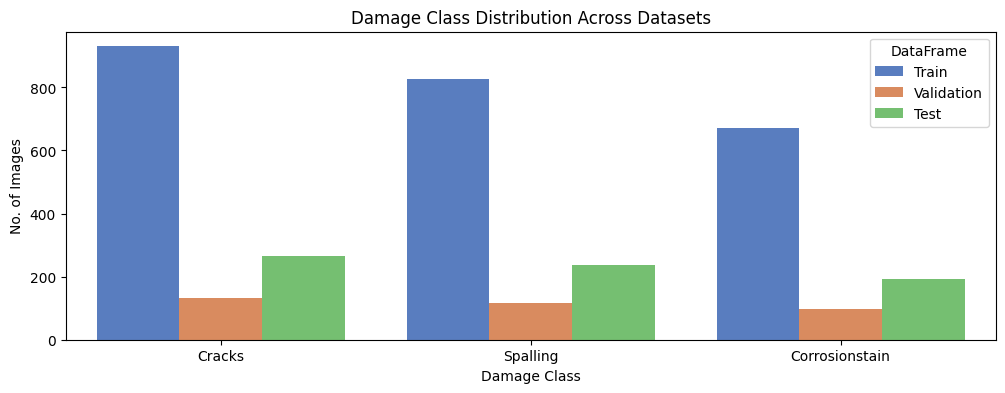

In [18]:
visualize_label_distribution(df_train, df_val, df_test)

The dataset is now more balanced.

### Set GPU memory growth

In [19]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# Create Generators

In [20]:
scale_gen = ImageDataGenerator(
    rescale=1.0/255,
)

In [21]:
IMG_WIDTH = IMG_HEIGHT = 128
BATCH_SIZE = 32

train_generator = scale_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = scale_gen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = scale_gen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2428 images belonging to 3 classes.
Found 347 images belonging to 3 classes.
Found 696 images belonging to 3 classes.


# Model Training

### Create Model

In [22]:
# Trial 2: Baseline Model but with more balanced classes
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dense(len(CLASSES), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/home/arbovitae/miniconda3/envs/tf218/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1734169628.773754   38161 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


### Model Summary

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 127008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,257,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,258,435 (62.02 MB)

 Trainable params: 16,258,435 (62.02 MB)

 Non-trainable params: 0 (0.00 B)

### Fit Model

In [24]:
model_hist = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/home/arbovitae/miniconda3/envs/tf218/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1734169635.780131   42764 service.cc:148] XLA service 0x7f908c01dfe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734169635.780278   42764 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-12-14 17:47:15.814113: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734169636.103380   42764 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/76 ━━━━━━━━━━━━━━━━━━━━ 3:35 3s/step - accuracy: 0.2500 - loss: 1.1597

I0000 00:00:1734169637.944074   42764 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - accuracy: 0.4320 - loss: 3.2353 - val_accuracy: 0.6542 - val_loss: 0.7639
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.7422 - loss: 0.6616 - val_accuracy: 0.7637 - val_loss: 0.6417
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.8246 - loss: 0.4753 - val_accuracy: 0.7118 - val_loss: 0.8091
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.8698 - loss: 0.3837 - val_accuracy: 0.7695 - val_loss: 0.6577
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.9238 - loss: 0.2828 - val_accuracy: 0.7839 - val_loss: 0.6573
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.9491 - loss: 0.1924 - val_accuracy: 0.7320 - val_loss: 0.7946
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9610 - loss: 0.1576 - val_accuracy: 0.7723 - val_loss: 0.7530
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.9816 - loss: 0.0942 - val_accuracy: 0.766

There were errors again in the first epoch. 

# Evaluate Model

### Evaluate the training and validation data

In [28]:
def plot_training_history(history):
    """
    Plot the training history of the model using Seaborn.

    Parameters:
    - history: History object containing the training history.

    Returns:
    - None (displays the plots)
    """
    
    # Extracting data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Creating DataFrames for plotting
    epochs = range(1, len(acc) + 1)
    
    # Data for accuracy
    acc_data = {
        'Epoch': list(epochs) * 2,
        'Value': acc + val_acc,
        'Metric': ['Training Accuracy'] * len(acc) + ['Validation Accuracy'] * len(val_acc)
    }
    acc_df = pd.DataFrame(acc_data)

    # Data for loss
    loss_data = {
        'Epoch': list(epochs) * 2,
        'Value': loss + val_loss,
        'Metric': ['Training Loss'] * len(loss) + ['Validation Loss'] * len(val_loss)
    }
    loss_df = pd.DataFrame(loss_data)

    # Creating side-by-side plots
    plt.figure(figsize=(12, 4))

    # Plotting Accuracy
    plt.subplot(1, 2, 1)
    sns.lineplot(data=acc_df, x='Epoch', y='Value', hue='Metric', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Loss
    plt.subplot(1, 2, 2)
    sns.lineplot(data=loss_df, x='Epoch', y='Value', hue='Metric', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


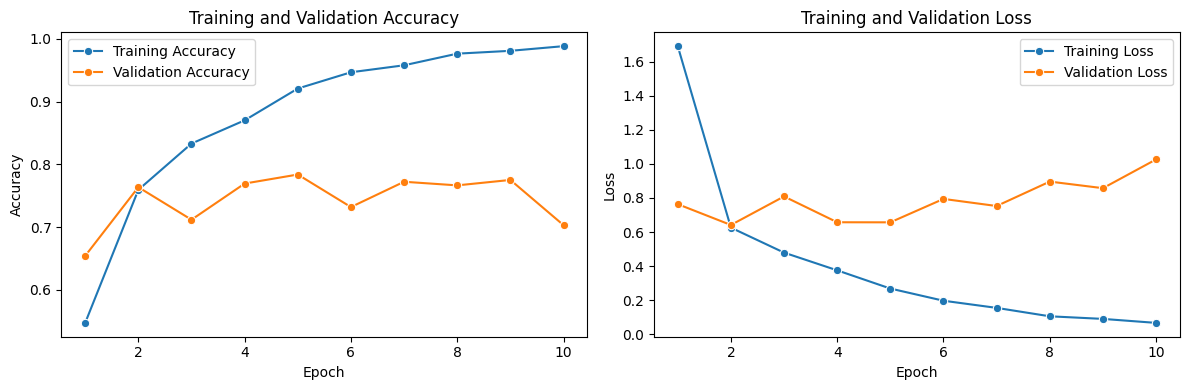

In [29]:
plot_training_history(model_hist)

### Evaluate the test data

In [30]:
model.evaluate(test_generator)

/home/arbovitae/miniconda3/envs/tf218/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.7240 - loss: 1.0891


[0.8916551470756531, 0.7801724076271057]

### Display predictions on the the testing images samples

In [31]:
def plot_predictions(model, test_generator, classes, num_images=32, grid_shape=(4, 8)):
    """
    Plots a grid of images from the test generator with their true and predicted labels.
    Labels are colored green if the prediction is correct, and red otherwise.

    Parameters:
    - model: Trained Keras model for predictions.
    - test_generator: A Keras ImageDataGenerator iterator for the test set.
    - classes: List of class names corresponding to the model's output.
    - num_images: Number of images to display. Default is 32.
    - grid_shape: Tuple defining the grid layout (rows, cols). Default is (4, 8).
    """
    # Get a batch of images and true labels from the test generator
    images, true_labels = next(test_generator)
    true_labels_indices = np.argmax(true_labels, axis=1)  # Convert one-hot to class indices

    # Predict the labels for the batch of images
    predicted_labels = model.predict(images)
    predicted_labels_indices = np.argmax(predicted_labels, axis=1)

    # Define a helper function to get the label and its color
    def get_label_color(true_idx, pred_idx):
        label_name = classes[true_idx]
        pred_name = classes[pred_idx]
        color = "green" if true_idx == pred_idx else "red"
        return f"{pred_name}", label_name, color

    # Determine grid size
    rows, cols = grid_shape
    total_slots = rows * cols
    num_images = min(num_images, total_slots, len(images))  # Adjust based on available images

    # Create the plot
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= num_images:  # Disable unused axes
            ax.axis('off')
            continue

        pred_name, label_name, color = get_label_color(true_labels_indices[i], predicted_labels_indices[i])

        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(f"Class: {label_name}\n Prediction:{pred_name}", color=color, fontsize=10)

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


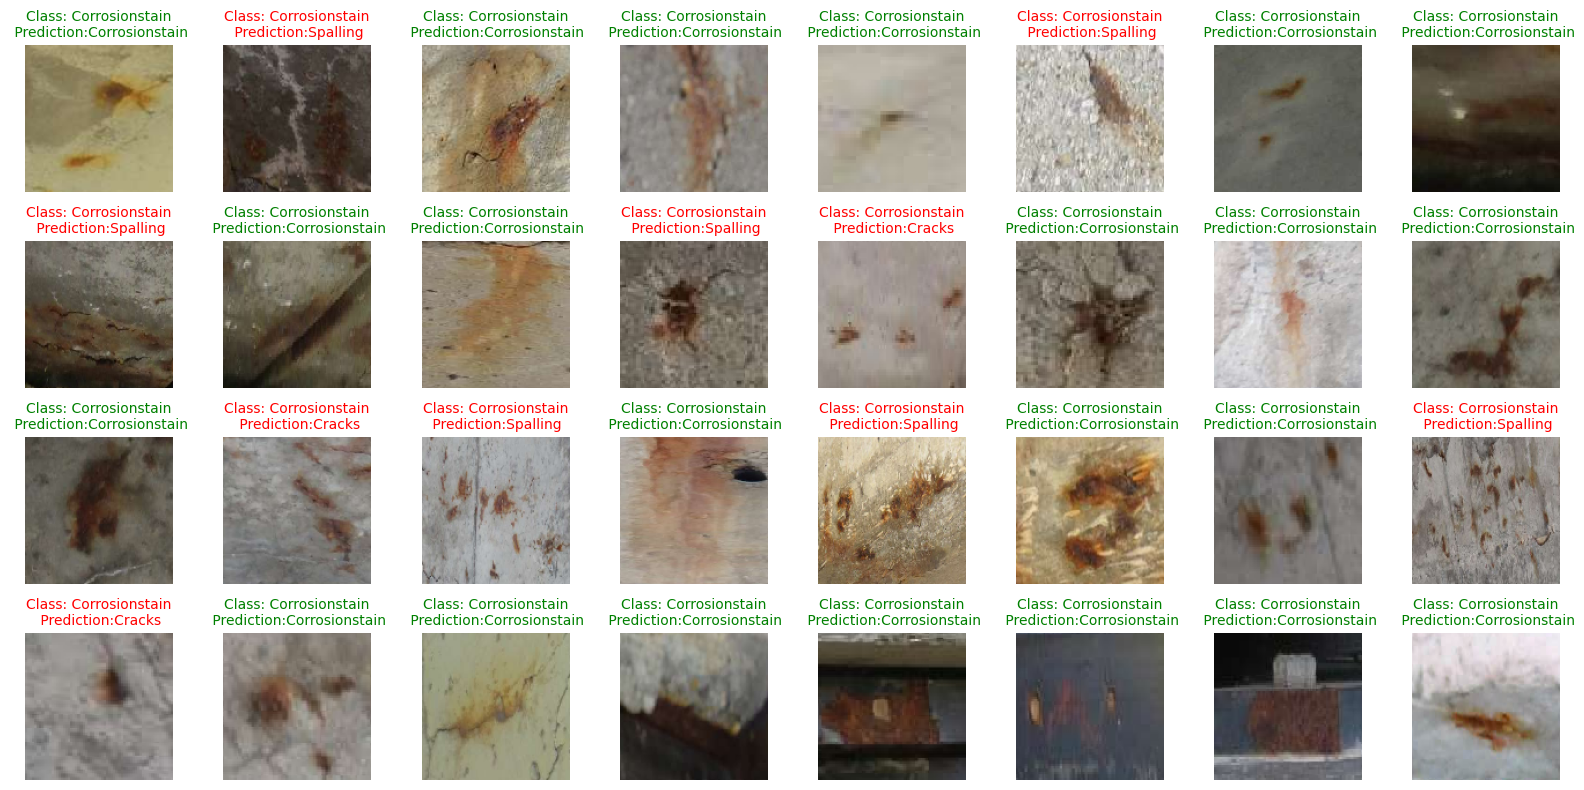

In [32]:
plot_predictions(model, test_generator, CLASSES, num_images=32, grid_shape=(4, 8))

### Create dataframe of the testing data

In [33]:
def create_evaluation_dataframe(model, test_generator, classes):
    """
    Creates a DataFrame summarizing the model's performance on the test data.

    Parameters:
    - model: Trained Keras model for predictions.
    - test_generator: A Keras ImageDataGenerator iterator for the test set.
    - classes: List of class names corresponding to the model's output.

    Returns:
    - DataFrame containing filenames, true labels, predicted labels, prediction confidence, and correctness.
    """
    # Get all images and labels from the test generator
    test_generator.reset()  # Reset the generator to ensure we process all test data
    filenames = test_generator.filenames
    true_labels_one_hot = test_generator.classes  # Class indices for true labels

    # Predict the labels for the entire test set
    predictions = model.predict(test_generator, verbose=1)
    predicted_labels_indices = np.argmax(predictions, axis=1)  # Class indices for predictions
    prediction_confidences = np.max(predictions, axis=1)  # Max confidence for each prediction

    # Map indices to class names
    true_labels_names = [classes[idx] for idx in true_labels_one_hot]
    predicted_labels_names = [classes[idx] for idx in predicted_labels_indices]

    # Determine correctness
    correct_predictions = (predicted_labels_indices == true_labels_one_hot)

    # Create the DataFrame
    df = pd.DataFrame({
        "Filename": filenames,
        "Damage Type": true_labels_names,
        "Prediction": predicted_labels_names,
        "Prediction Confidence": prediction_confidences,
        "Correct Prediction": correct_predictions
    })

    return df


In [34]:
eval_df = create_evaluation_dataframe(model, test_generator, CLASSES)

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step


### Check the average prediction confidence

In [35]:
def plot_average_confidence(eval_df):
    """
    Plot average confidence for each class.
    Parameters:
    - eval_df: DataFrame containing evaluation results.
    
    Returns:
    - None (displays the plot)
    """
    
    # Calculate average confidence
    average_confidence = eval_df.groupby('Prediction')['Prediction Confidence'].mean().reset_index()
    average_confidence.columns = ['Prediction', 'Average Confidence']
    
    # Create a bar plot with hue set to 'Prediction' and legend turned off
    plt.figure(figsize=(8, 4))
    sns.barplot(x='Prediction', y='Average Confidence', data=average_confidence, hue='Prediction', palette='viridis', legend=False)
    plt.title('Average Confidence by Prediction')
    plt.xlabel('Prediction')
    plt.ylabel('Average Confidence (%)')
    
    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    plt.tight_layout()
    plt.show()

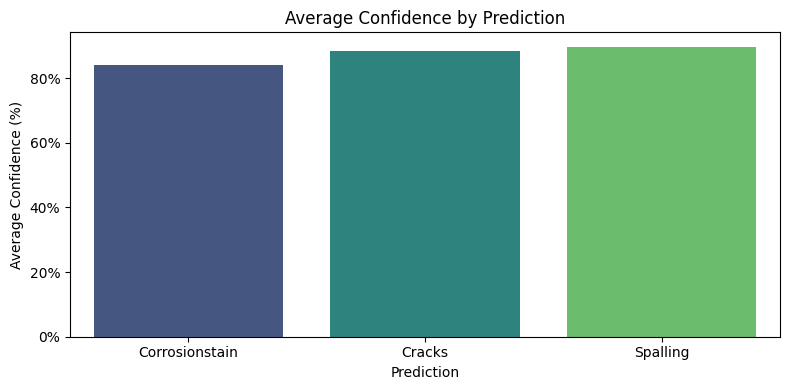

In [36]:
plot_average_confidence(eval_df)

The prediction confidence is now more balancecd between the classes.

### Check the average prediction accuracy

In [37]:
def plot_accuracy_per_class(eval_df):
    """
    Plots the accuracy per class for each damage type.
    Parameters:
    - eval_df: DataFrame containing evaluation results.
    
    Returns:
    - None (displays the plot)
    """
    # Calculate accuracy per class
    accuracy_per_class = eval_df.groupby('Damage Type').apply(
        lambda x: (x['Prediction'] == x['Damage Type']).mean()
    ).reset_index()
    
    accuracy_per_class.columns = ['Damage Type', 'Accuracy']
    
    # Create a box plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Damage Type', y='Accuracy', data=accuracy_per_class, palette='viridis')
    
    plt.title('Accuracy per Damage Type')
    plt.xlabel('Damage Type')
    plt.ylabel('Accuracy (%)')
    
    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_38161/1796552315.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_per_class = eval_df.groupby('Damage Type').apply(
/tmp/ipykernel_38161/1796552315.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Damage Type', y='Accuracy', data=accuracy_per_class, palette='viridis')


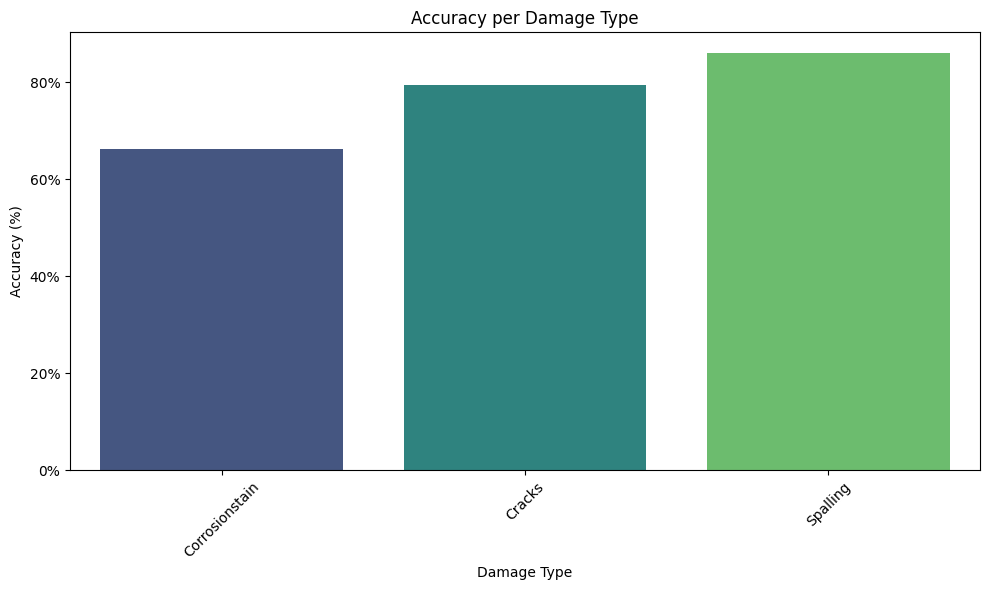

In [38]:
plot_accuracy_per_class(eval_df)

Corrosion stain has the lowest accuracy.

### Confusion matrix

In [39]:
def plot_class_correlation(y_true, y_pred, class_names):
    """
    Plots a confusion matrix for the given true and predicted labels.
    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - class_names: List of class names
    
    Returns:
    - None (displays the plot)
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    
    plt.title('Confusion Matrix\n')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

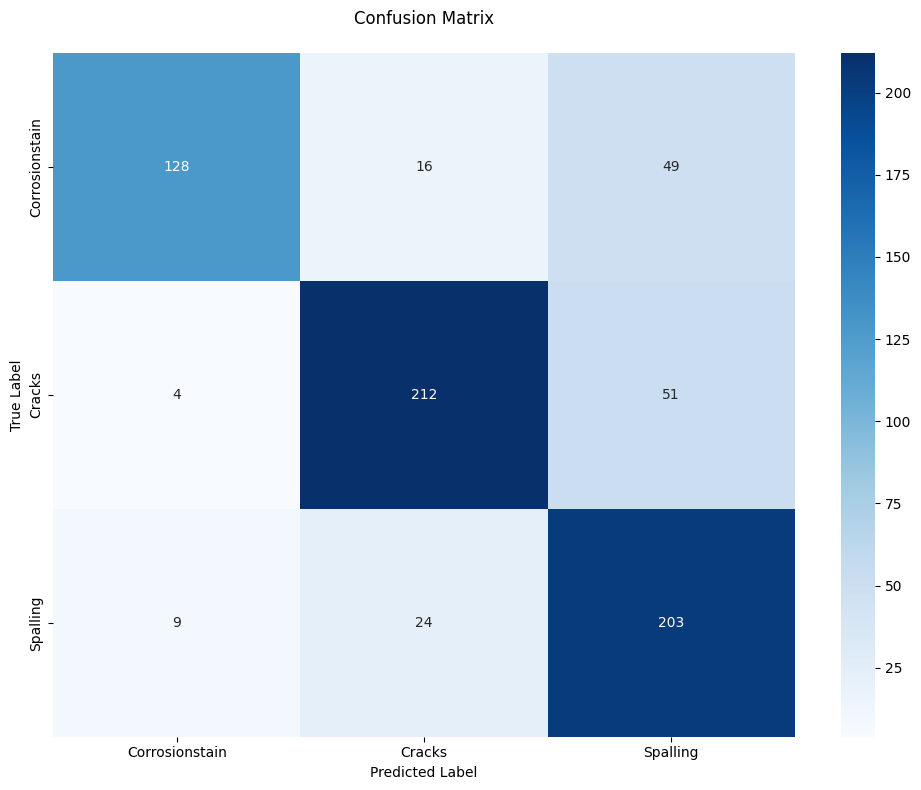

In [40]:
plot_class_correlation(eval_df['Damage Type'], eval_df['Prediction'], eval_df['Damage Type'].unique())

Other labels seem to be more misclassified as Spalling.

# Save model

In [1]:
model.save("models/trial_2.keras")

NameError: name 'model' is not defined

In [42]:
eval_df.to_csv('dataframes/trial_2_df.csv', index=False)